In [99]:
import pandas as pd
import numpy as np
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Import the necessary module's
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler

C:\Users\svval\AppData\Local\Temp\ipykernel_36288\3717358247.py:8: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')
C:\Users\svval\AppData\Local\Temp\ipykernel_36288\3717358247.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u"config InlineBackend.figure_format='retina'")


#### Plot functions

* Funciones personalizadas creadas para visualizar los datos

** References: ** 
*<https://stackoverflow.com/questions/9497524/displaying-3-histograms-on-1-axis-in-a-legible-way-matplotlib>*
*<>*

In [100]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')
    
def get_hist(var1,var2,values_range=[0,1],nbins=20,normed=True,name_image='2hist.png'):
    
    common_params = dict(bins=nbins,range=values_range,normed=normed)
    plt.subplots_adjust(hspace=.8)
    plt.subplot(311)
    plt.title('Default')
    #plt.hist(df.popularity, **common_params)
    plt.hist(var1, **common_params)
    plt.hist(var2, **common_params)
    plt.subplot(312)
    plt.title('Skinny shift - 2 at a time')
    plt.hist((var1, var2), **common_params)
    plt.subplot(313)
    common_params['histtype'] = 'step'
    plt.title('With steps')
    #plt.hist(df.popularity, **common_params)
    plt.hist(var1, **common_params)
    plt.hist(var2, **common_params)

    plt.savefig(name_image)
    plt.show()

In [101]:
def expected_values(var1,var2):
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    return expected

def chi2_test(var1,var2,alpha=0.95):
    #Creamos la tabla de contingencia con los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    #Creamos la tabla de valores esperados
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    #Creamos la tabla de contingencia sin los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2)
    #calculamos el valor calculado de chi2
    chi_squared_stat = (((contingencyTable-expected)**2)/expected).sum().sum()
    #calculamos los grados de libertad
    dof=(len(contingencyTable.columns)-1)*(len(contingencyTable.index)-1)
    #calculamos el valor crítico de chi2
    crit = chi2.ppf(q = alpha,df = dof)
    #calulamos el p-valor
    p_value = 1 - chi2.cdf(x=chi_squared_stat,df=dof)
    #testeamos la hipótesis nula de independencia entre las variables
    if(chi_squared_stat<=crit):
        print('no hay evidencia suficiente para rechazar H0, los valores son independientes y el p-valor es: {}'
              '\n el p-valor es:'.format(round(p_value,4)))
        #print("los valores esperados son: "+ str(expected))
    else:
        print('Se rechaza H0, no hay evidencia para decir que los valores son independientes'
              '\n y el p-valor es: {}'.format(round(p_value,4)))
        #print("los valores esperados son: "+ str(expected))

## EDA

* En esta etapa realizaremos la exploración y comprensión de la estructura/distribución de los datos. Para ello realizaremos las siguientes tareas:

    * **Caracterización general del dataset:** En esta etapa revisaremos las características del dataset generales del 
      dataset en cuanto a estructura (número de registros y variables, significado y tipos de variables, cantidad de 
      NA's)      

    * **Análisis univariado:** En donde evaluaremos cada variable por si sola en cuanto a su distribución y 
      características propias (características de los NA's, outliers, valores fuera de rango, etc), así como las 
      diferencias en ellas (si es que existen) cuando pertenencen a canciones de reggaeton y cuando no.
      
    * **Análisis multivariado:** Se evaluarán las relaciones entre las variables y la influencia conjunta con respecto a 
      la variable target (cuando es reggaeton y cuando no)

### Caracterización general del dataset

* Hay 2230 registros de canciones de todo tipo y 70 de reggaeton. Las variables para ambos dataset son similares a excpeción de *time_signature* que solo está presente en las canciones de todo tipo.


* Las variables *key* y *mode* son enteros que representan categorías, mientras que *duration* es una variable que representa el tiempo en milisegundo. El resto de las variables corresponden a distintos score numéricos que representan características de los track como popularidad, qué tan apto es para el baile, qué tan vocal o instrumental es, etc.


* Podemos ver que la cantidad de NA's es 0 para los track de reggaeton y muy baja para los track de otro tipo, en donde ninguna variable tiene más de 8 valores NAs, correspondientes a un 0.36% de los datos. 


* **Dada la baja proporción de NAs y que estos corresponden al dataset que contiene la clase mayoritaria no se harán imputaciones y se trabajará solo con los datos completos.**

In [102]:
df_todotipo=pd.read_csv('data_todotipo.csv',encoding='utf-8',sep=',')
del df_todotipo['Unnamed: 0']
print(df_todotipo.shape)
df_todotipo.head(3)

(2230, 15)


,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature,id_new
0,68.0,0.650,0.884,1.0,-3.557,1.0,0.0326,0.048200,0.154,0.135,0.377,125.998,200952.0,4.0,71
1,59.0,0.588,0.623,11.0,-8.027,0.0,0.0304,0.000288,0.451,0.184,0.169,135.993,417188.0,4.0,72
2,61.0,0.577,0.880,6.0,-2.916,1.0,0.0357,0.335000,0.896,0.143,0.259,127.951,204375.0,4.0,73


In [103]:
df_todotipo.dtypes

popularity          float64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration            float64
time_signature      float64
id_new                int64
dtype: object

In [104]:
qsna=df_todotipo.shape[0]-df_todotipo.isnull().sum(axis=0)
qna=df_todotipo.isnull().sum(axis=0)
ppna=round(100*(df_todotipo.isnull().sum(axis=0)/df_todotipo.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
danceability,2222,8,0.36
energy,2222,8,0.36
key,2222,8,0.36
loudness,2222,8,0.36
mode,2222,8,0.36
speechiness,2222,8,0.36
acousticness,2222,8,0.36
instrumentalness,2222,8,0.36
liveness,2222,8,0.36
valence,2222,8,0.36


In [105]:
df_todotipo=df_todotipo.dropna(how='any',axis=0).copy()
df_todotipo.shape

(2222, 15)

In [106]:
df_reggaeton=pd.read_csv('data_reggaeton.csv',encoding='utf-8',sep=',')
del df_reggaeton['Unnamed: 0']
print(df_reggaeton.shape)
df_reggaeton.head()

(70, 14)


,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,id_new
0,68,0.826,0.704,9,-7.527,1,0.1170,0.1890,0.000048,0.0617,0.741,94.013,205000,1
1,61,0.641,0.693,8,-7.327,1,0.1630,0.0169,0.000000,0.2190,0.899,214.058,184413,2
2,67,0.771,0.815,1,-5.423,0,0.0719,0.1610,0.000020,0.1890,0.524,94.016,205520,3
3,63,0.743,0.787,1,-5.402,1,0.2620,0.0352,0.000000,0.0732,0.719,192.117,172680,4
4,63,0.876,0.692,10,-6.429,1,0.1040,0.1280,0.000000,0.2490,0.757,95.032,227280,5


In [107]:
df_reggaeton.dtypes

popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration              int64
id_new                int64
dtype: object

In [108]:
qsna=df_reggaeton.shape[0]-df_reggaeton.isnull().sum(axis=0)
qna=df_reggaeton.isnull().sum(axis=0)
ppna=round(100*(df_reggaeton.isnull().sum(axis=0)/df_reggaeton.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
popularity,70,0,0.0
danceability,70,0,0.0
energy,70,0,0.0
key,70,0,0.0
loudness,70,0,0.0
mode,70,0,0.0
speechiness,70,0,0.0
acousticness,70,0,0.0
instrumentalness,70,0,0.0
liveness,70,0,0.0


### Análisis univariado

##### Vemos que claramente el valor más repetido en la variable señal de tiempo global estimada de la pista es 4, con el 90% de los registros. Dado que la variable no está presenten en las canciones de reggaeton vamos a eliminarla del dataset, pues no la podemos usar para predecir.

count    2222.000000
mean        3.902790
std         0.390686
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: time_signature, dtype: float64


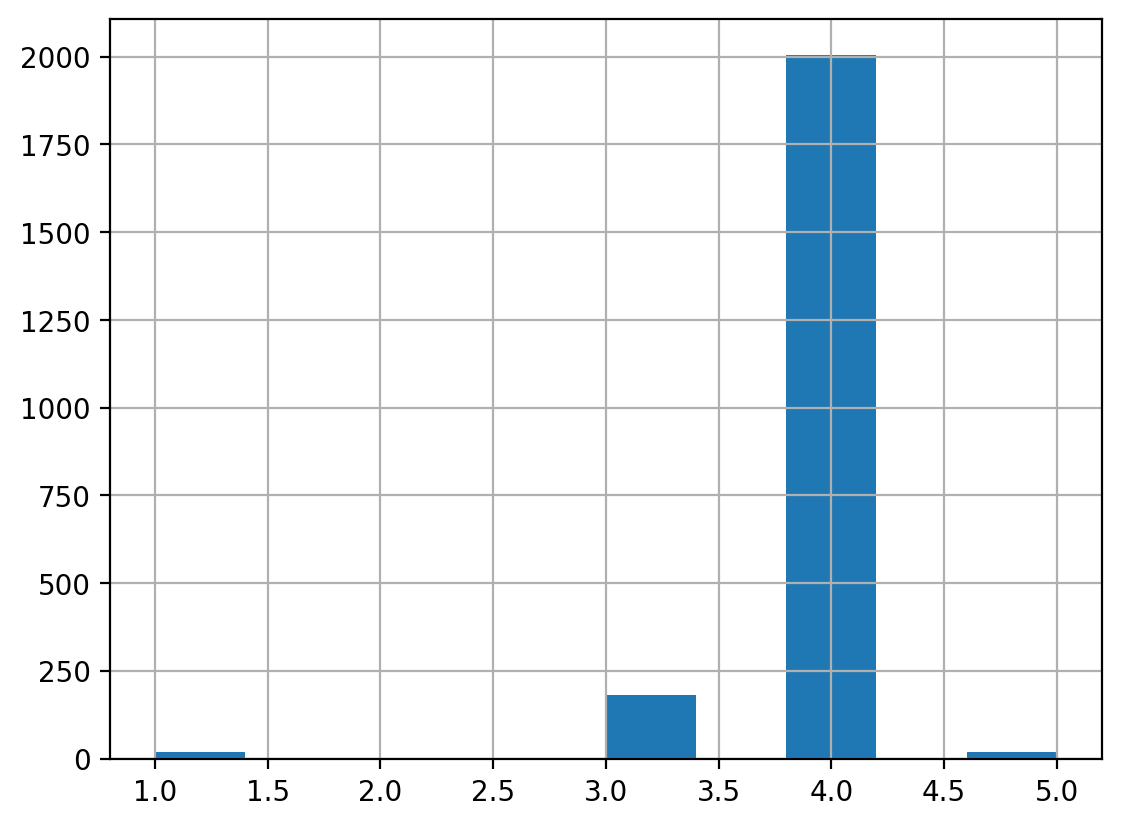

In [109]:
print(df_todotipo.time_signature.describe())
df_todotipo.time_signature.hist(bins=10);

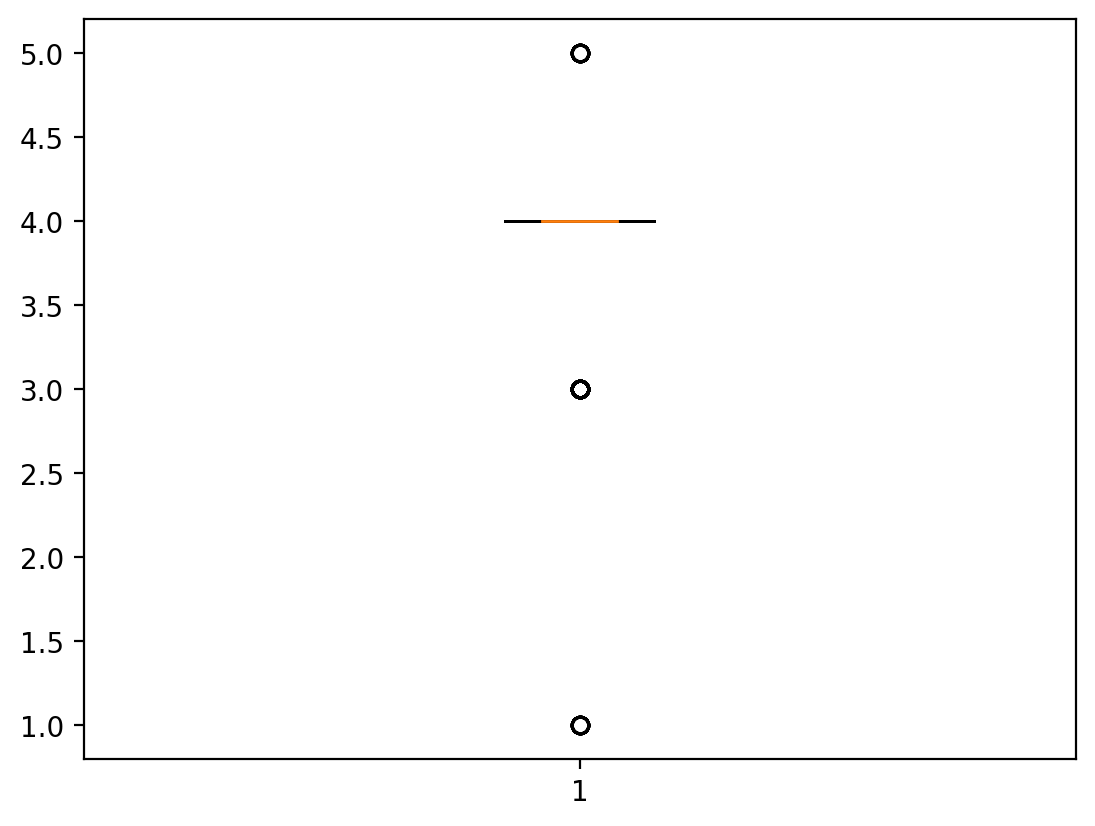

In [110]:
plt.boxplot(df_todotipo.time_signature,'rs');

In [111]:
del df_todotipo['time_signature']

#### Union de los datasets

* Para analizar el resto de las variables vamos a trabajar con el dataset ya unido, de tal forma que podamos comparar la variable cuando es reggaeton y cuando no de forma más simple y rápida.


* Para ello definiremos una variable *es_reggaeton* como 1 cuando sea un track de reggaeton y con valor 0 en cualquier otro caso. Posteriormente, unificaremos los tipos de datos de ambos dataset y finalmente haremos la unión.

In [112]:
df_reggaeton['es_reggaeton']=1
df_todotipo['es_reggaeton']=0

In [113]:
df_reggaeton['popularity']=df_reggaeton.popularity.astype('float64')
df_reggaeton['duration']=df_reggaeton.duration.astype('float64')

In [114]:
df=pd.concat([df_reggaeton,df_todotipo]).copy()
print(df.shape)
df.head()

(2292, 15)


,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,id_new,es_reggaeton
0,68.0,0.826,0.704,9.0,-7.527,1.0,0.1170,0.1890,0.000048,0.0617,0.741,94.013,205000.0,1,1
1,61.0,0.641,0.693,8.0,-7.327,1.0,0.1630,0.0169,0.000000,0.2190,0.899,214.058,184413.0,2,1
2,67.0,0.771,0.815,1.0,-5.423,0.0,0.0719,0.1610,0.000020,0.1890,0.524,94.016,205520.0,3,1
3,63.0,0.743,0.787,1.0,-5.402,1.0,0.2620,0.0352,0.000000,0.0732,0.719,192.117,172680.0,4,1
4,63.0,0.876,0.692,10.0,-6.429,1.0,0.1040,0.1280,0.000000,0.2490,0.757,95.032,227280.0,5,1


* Nuestra primera tarea será hacer el encoding de las variables categóricas para que Python las entienda como tal

** Referencias: **
*<http://pbpython.com/categorical-encoding.html>*

In [115]:
df.loc[:,"key_code"] = df.key.astype('category')
df.loc[:,"mode_code"] = df['mode'].astype('category')
del df['key']
del df['mode']
del df['id_new']
df.loc[:,"es_reggaeton"] = df.es_reggaeton.astype('category')
df.dtypes

popularity           float64
danceability         float64
energy               float64
loudness             float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration             float64
es_reggaeton        category
key_code            category
mode_code           category
dtype: object

In [116]:
df.describe()

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
count,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2.292000e+03
mean,52.250436,0.572839,0.612483,-9.540138,0.069336,0.340752,0.208805,0.179925,0.536097,117.959250,2.351487e+05
std,17.277718,0.167854,0.280018,6.086132,0.064496,0.357389,0.348070,0.153361,0.273738,28.602015,8.910156e+04
min,0.000000,0.062700,0.001810,-42.117000,0.023100,0.000002,0.000000,0.018000,0.027900,33.579000,4.666700e+04
25%,43.000000,0.459000,0.416750,-11.192750,0.035700,0.022300,0.000004,0.089675,0.304750,96.100500,1.873198e+05
50%,56.000000,0.584000,0.680000,-7.892000,0.046400,0.181000,0.001310,0.119000,0.549000,117.078500,2.252305e+05
75%,64.000000,0.700000,0.848000,-5.672000,0.072500,0.650500,0.274750,0.222250,0.770000,133.130250,2.717302e+05
max,98.000000,0.944000,0.998000,-0.262000,0.668000,0.996000,0.985000,0.978000,0.982000,214.058000,1.499600e+06


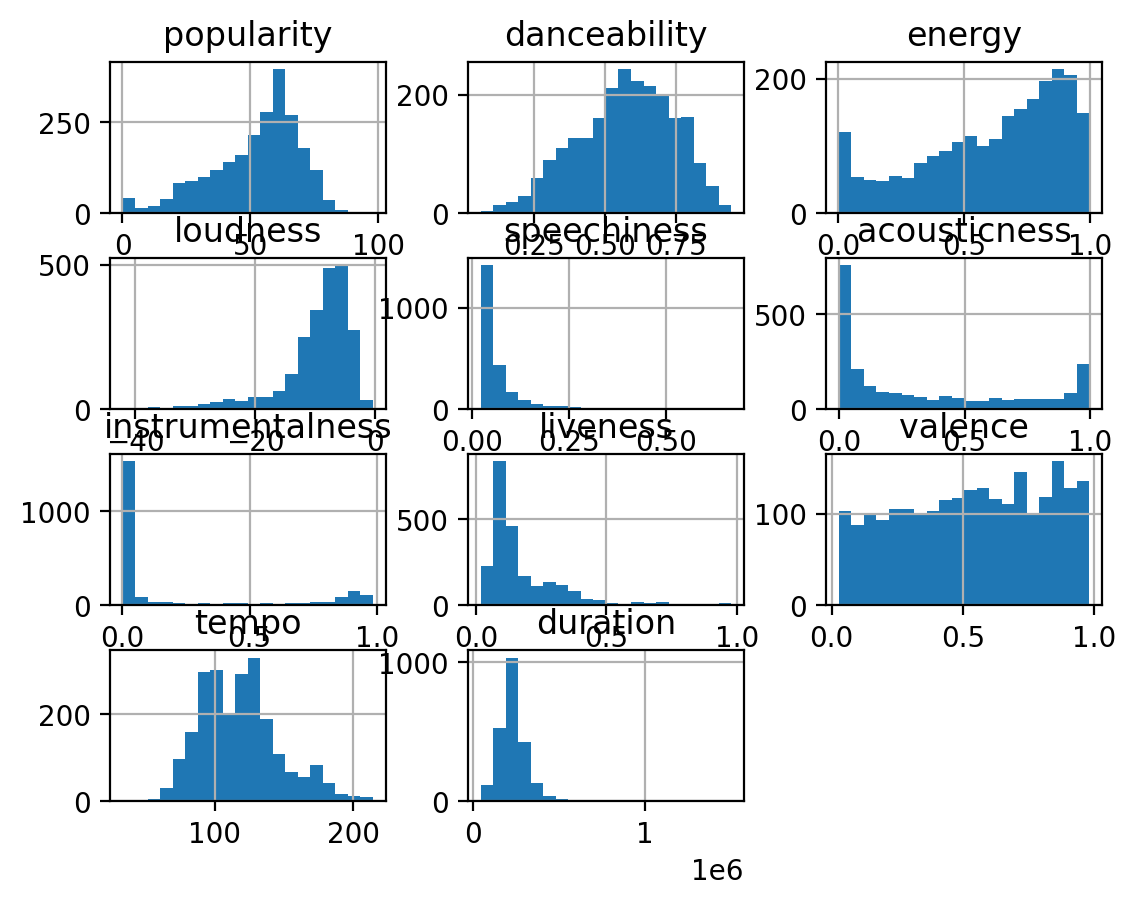

In [117]:
df.hist(bins=20);

* **Popularity:** Para la variabe popularity podemos observar una distribución levemente cargada al costado derecho (con la media levemente más a la derecha de la mediana y mayor frecuencia de la media hacia la derecha) con menor dispersión en las canciones de reggaeton que en las de otro tipo (esperable por la variedad de géneros del segundo) pero con las medias y medianas similares entre las canciones que tienen y no tienen reggaeton. Sin embargo, es posible que como las canciones de reggaeton no tienen valores menores que 27 y valores mayores a 75, exista un rango de valores en los extremos que si genere diferencias en el modelo. Por lo tanto, es candidata a ser variable significativa.

count    70.000000
mean     56.957143
std      10.703427
min      27.000000
25%      52.250000
50%      59.000000
75%      63.000000
max      75.000000
Name: popularity, dtype: float64


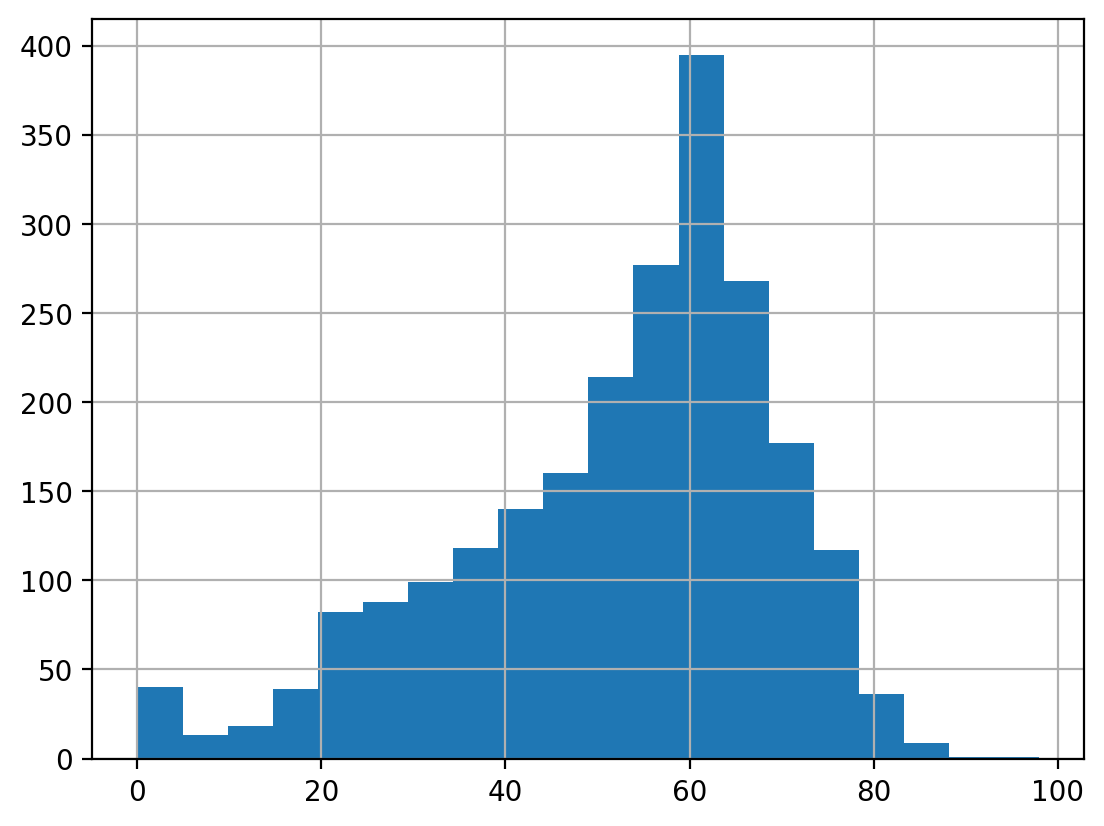

In [118]:
print(df[df.es_reggaeton==1].popularity.describe())
df.popularity.hist(bins=20);

AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

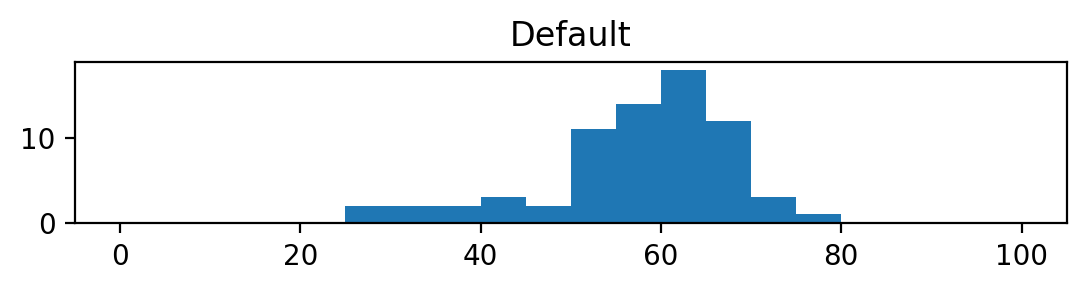

In [119]:
get_hist(df[df.es_reggaeton==1].popularity,df[df.es_reggaeton==0].popularity,
         values_range=[0,100],nbins=20,normed=True,name_image='2hist_popularity.png')

               count       mean        std   min    25%   50%   75%   max
es_reggaeton                                                             
0             2222.0  52.102160  17.425519   0.0  42.00  56.0  64.0  98.0
1               70.0  56.957143  10.703427  27.0  52.25  59.0  63.0  75.0


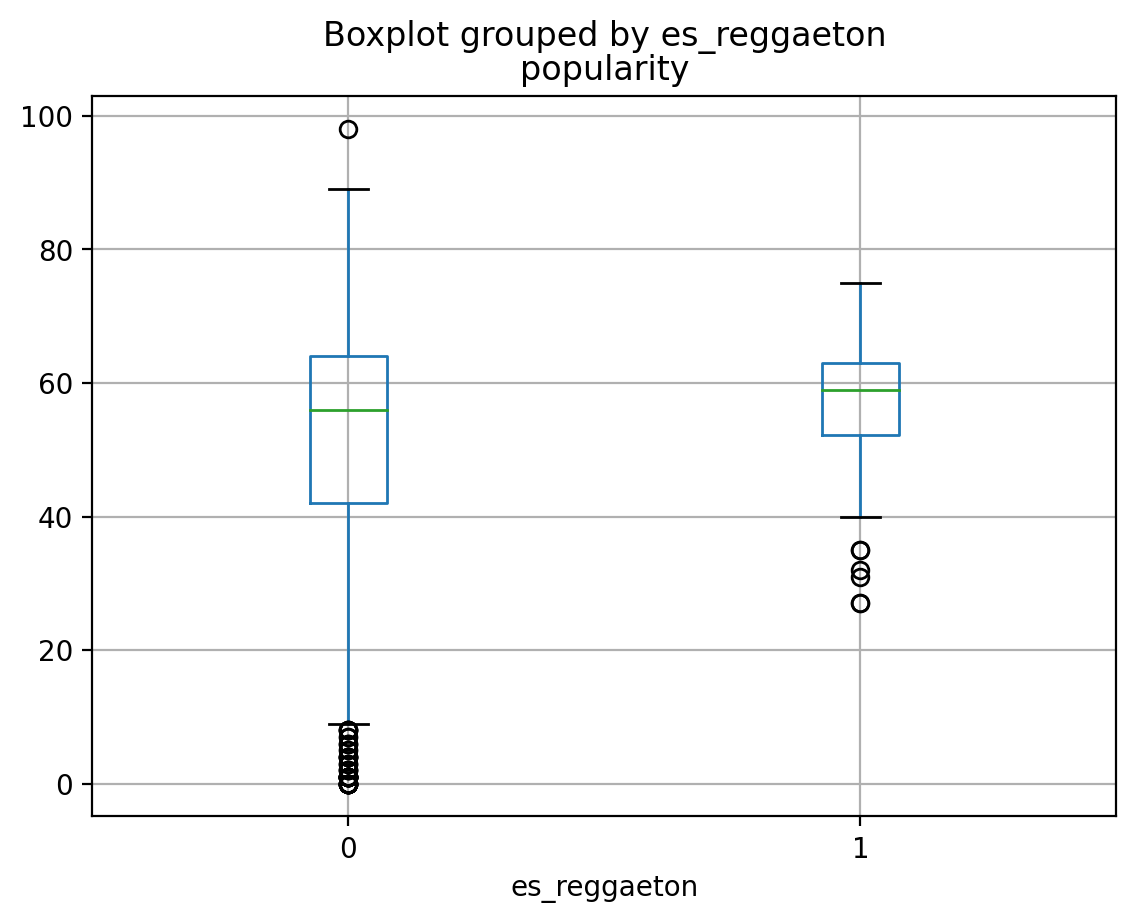

In [ ]:
print(df.groupby('es_reggaeton')['popularity'].describe())
df.boxplot(column='popularity',by='es_reggaeton');

* **Danceability:** Para la variabe danciability la distribución es claramente distinta entre las canciones que son reggaeton y las que no, en donde las que si son presentan un valor de danceability significativamente mayor como se puede apreciar tanto en el histograma como el boxplot combinado.**En consecuencia, esta es una variable que puede ser diferenciadora para aquellos registros con bajo danciability que se espera no entren en la categoría de reggaeton**

count    2292.000000
mean        0.572839
std         0.167854
min         0.062700
25%         0.459000
50%         0.584000
75%         0.700000
max         0.944000
Name: danceability, dtype: float64


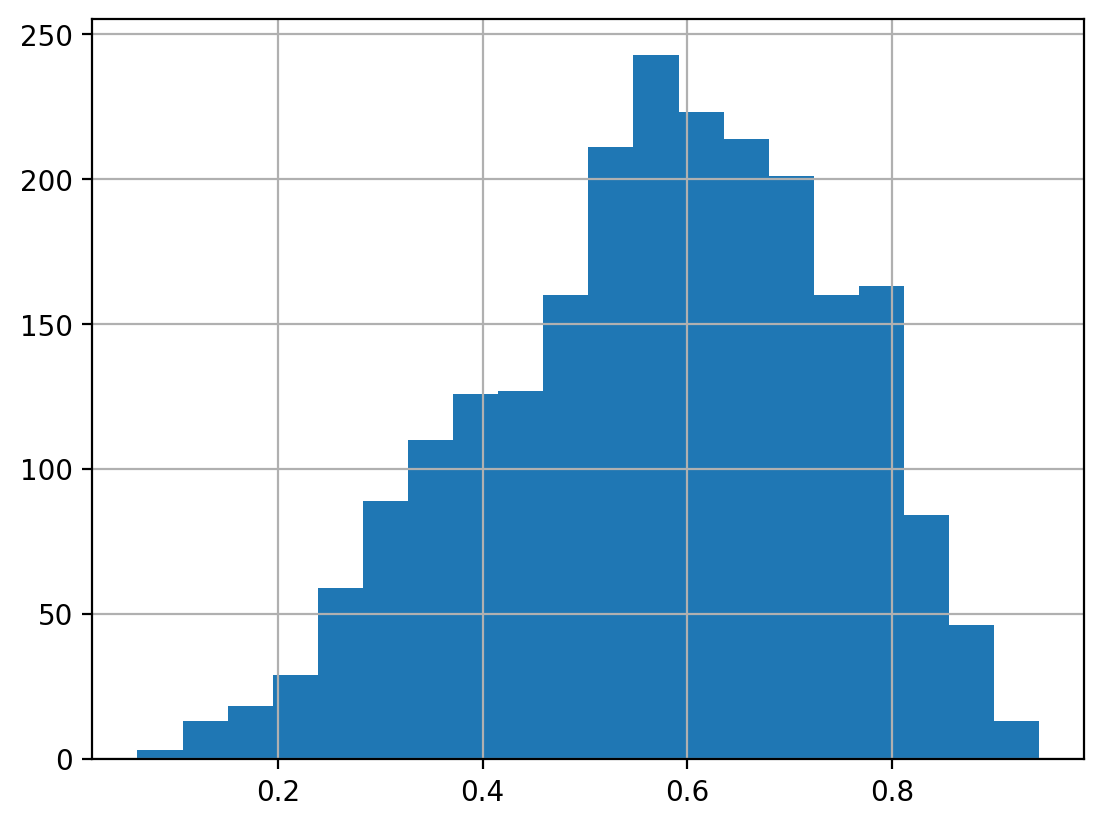

In [ ]:
print(df.danceability.describe())
df.danceability.hist(bins=20);

AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

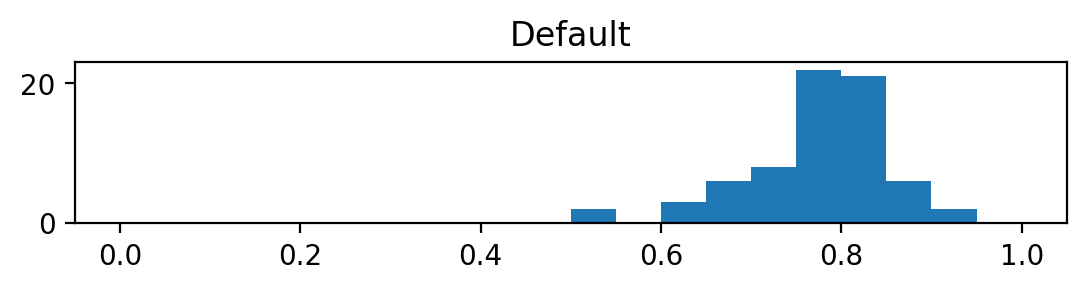

In [ ]:
get_hist(df[df.es_reggaeton==1].danceability,df[df.es_reggaeton==0].danceability,
         values_range=[0,1],nbins=20,normed=True,name_image='2hist_danceability.png')

               count      mean       std     min      25%    50%      75%  \
es_reggaeton                                                                
0             2222.0  0.566439  0.165887  0.0627  0.45600  0.579  0.69075   
1               70.0  0.776000  0.080724  0.5030  0.74325  0.792  0.82750   

                max  
es_reggaeton         
0             0.942  
1             0.944  


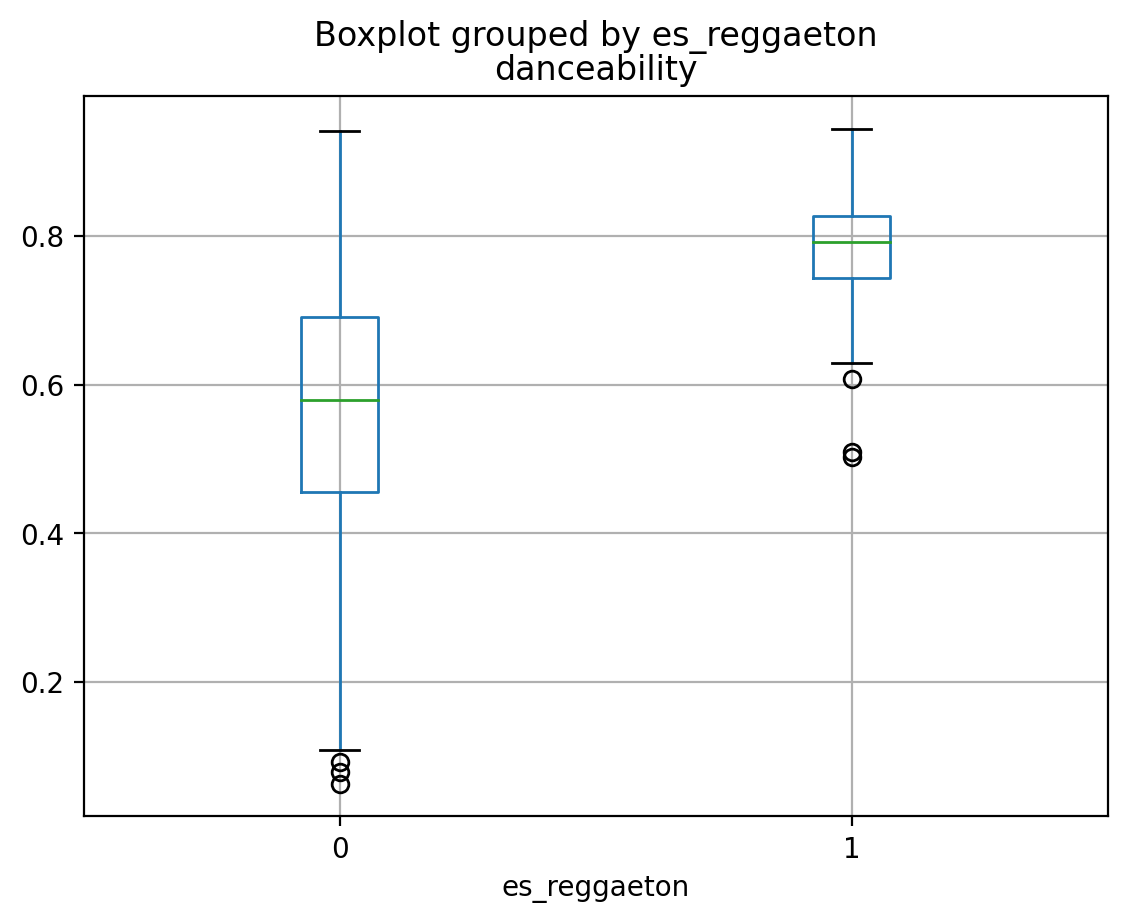

In [ ]:
print(df.groupby('es_reggaeton')['danceability'].describe())
df.boxplot(column='danceability',by='es_reggaeton');

* **Energy:** Para la variabe energy la distribución es claramente distinta entre las canciones si son reaggaeton y que **solo** presentan un valor de intesidad y actividad alto (mayor a 0.5), mientras que en las canciones que no son reggaeton, si bien hay una predominancia de las canciones de alta intensidad y actividad, al menos un 30% de los datos presenta niveles bajos,algo que nunca ocurre en los reggaeton. **En consecuencia, esta es una variable que puede ser diferenciadora para aquellos registros con bajo energy que se espera no entren dentro de la categoría de reggaeton**

count    2292.000000
mean        0.612483
std         0.280018
min         0.001810
25%         0.416750
50%         0.680000
75%         0.848000
max         0.998000
Name: energy, dtype: float64


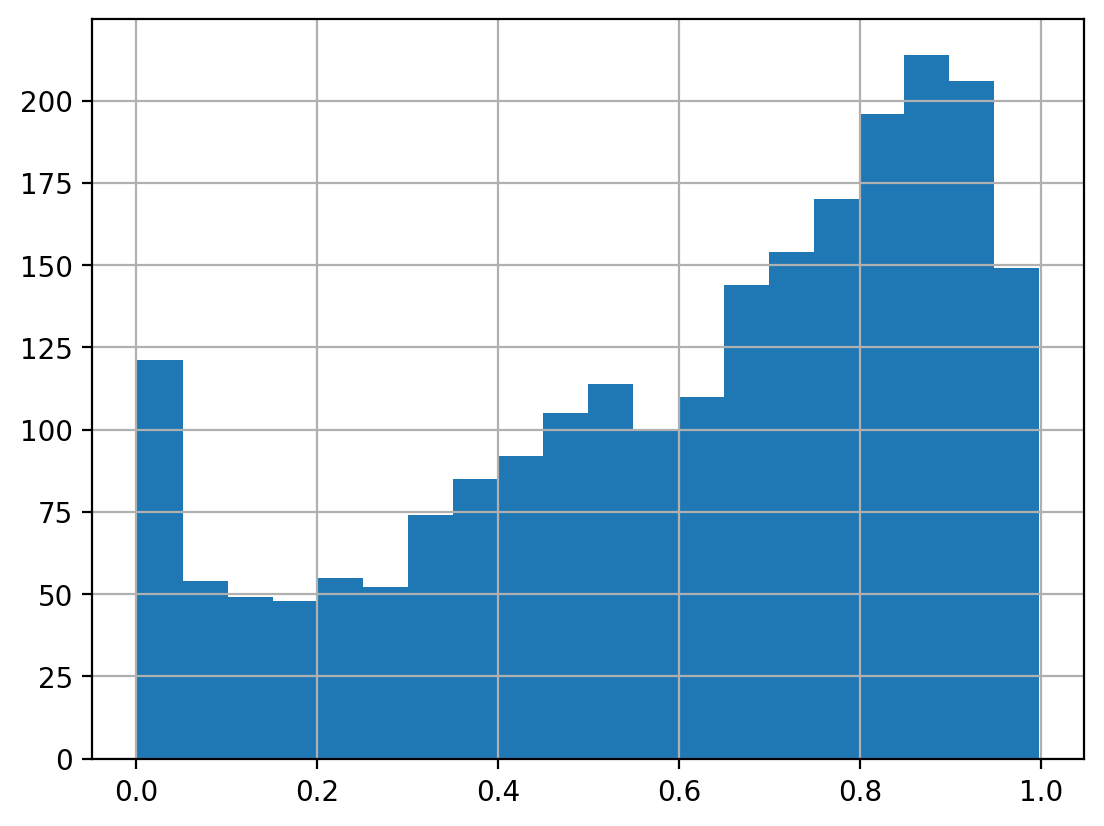

In [ ]:
print(df.energy.describe())
df.energy.hist(bins=20);

AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

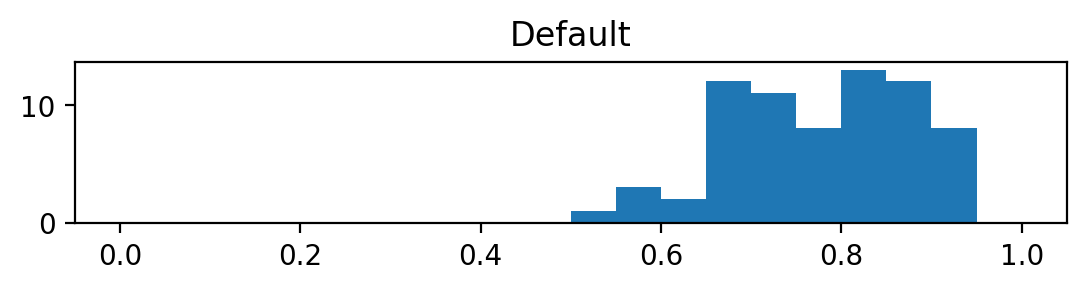

In [ ]:
get_hist(df[df.es_reggaeton==1].energy,df[df.es_reggaeton==0].energy,
         values_range=[0,1],nbins=20,normed=True,name_image='2hist_energy.png')

               count      mean       std      min      25%    50%     75%  \
es_reggaeton                                                                
0             2222.0  0.607263  0.282298  0.00181  0.40625  0.671  0.8470   
1               70.0  0.778171  0.097774  0.53300  0.70025  0.790  0.8635   

                max  
es_reggaeton         
0             0.998  
1             0.946  


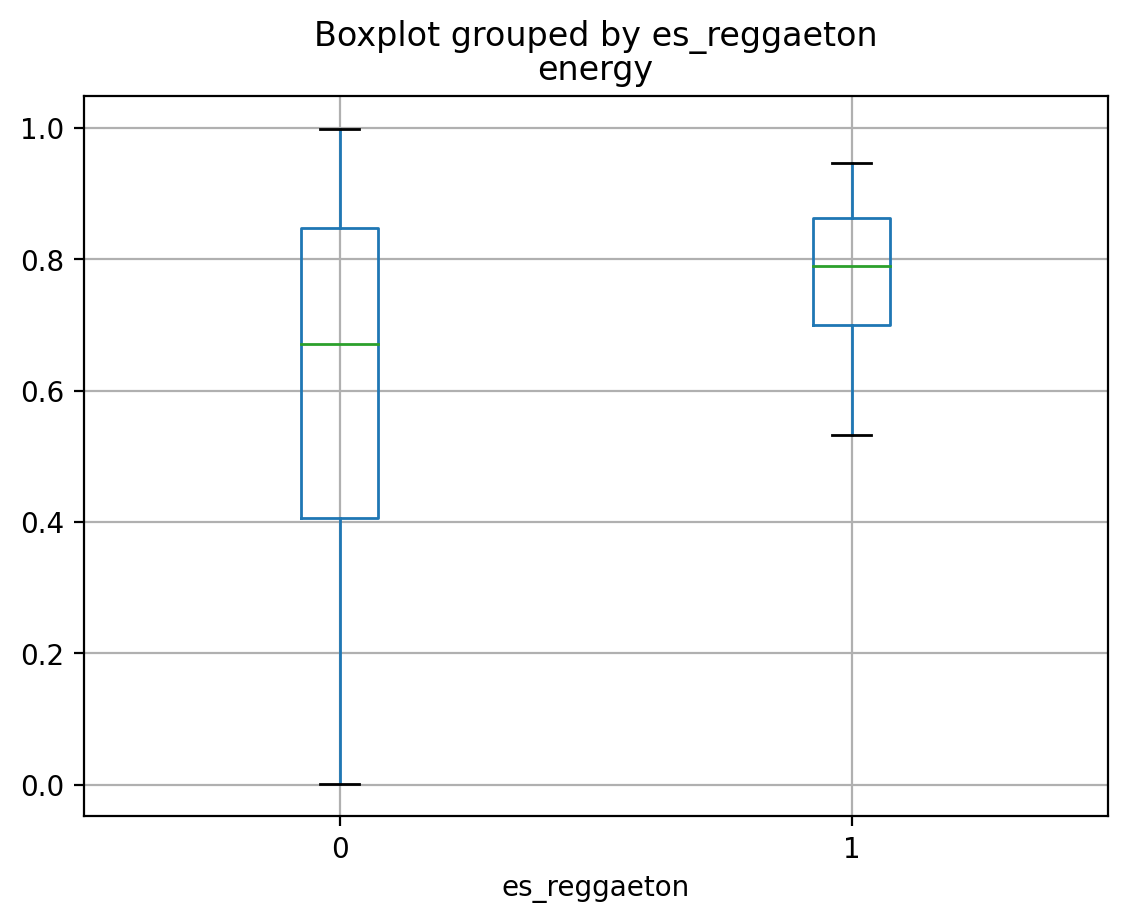

In [120]:
print(df.groupby('es_reggaeton')['energy'].describe())
df.boxplot(column='energy',by='es_reggaeton');

* **Acousticness:** Para la variabe accousticnes se puede comprobar facilmente que los valores para el reggaeton jamás serán altos, de hecho el máximo es 0.56. **En consecuencia, esta es una variable que puede ser diferenciadora para aquellos registros con alto accousticnes que se espera no entren dentro de la categoría de reggaeton**

count    2292.000000
mean        0.340752
std         0.357389
min         0.000002
25%         0.022300
50%         0.181000
75%         0.650500
max         0.996000
Name: acousticness, dtype: float64


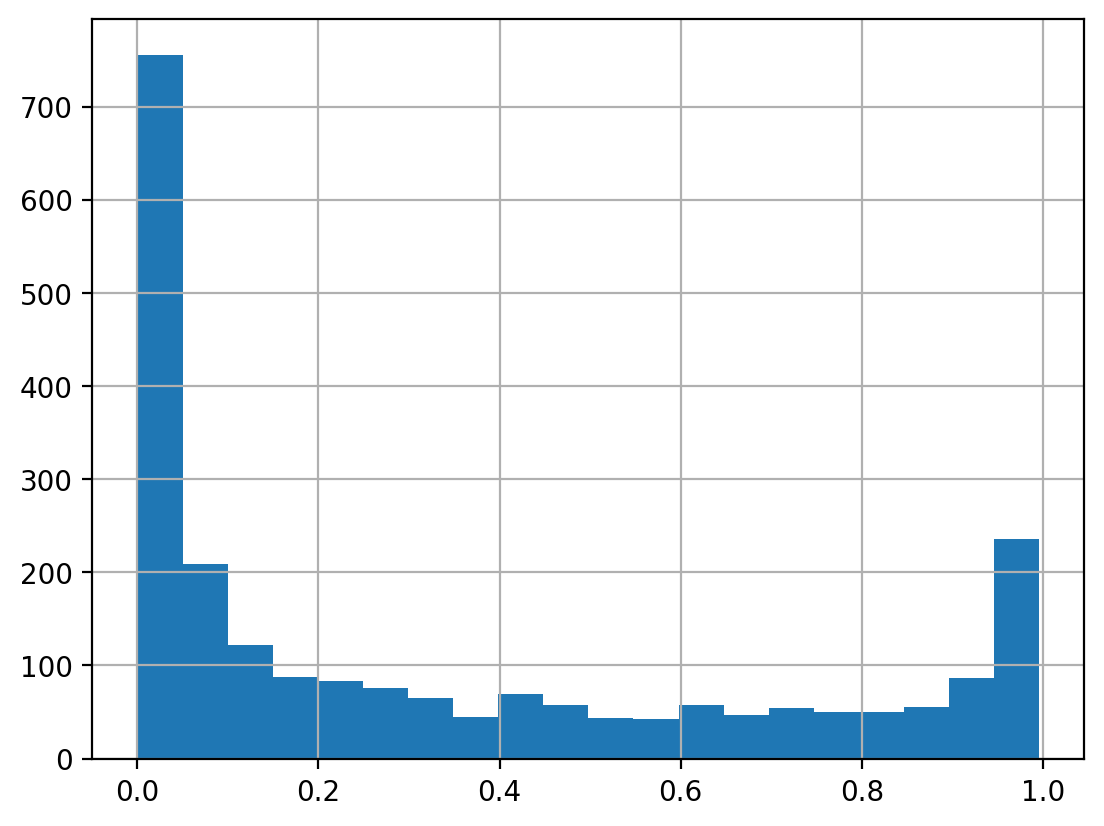

In [121]:
print(df.acousticness.describe())
df.acousticness.hist(bins=20);

AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

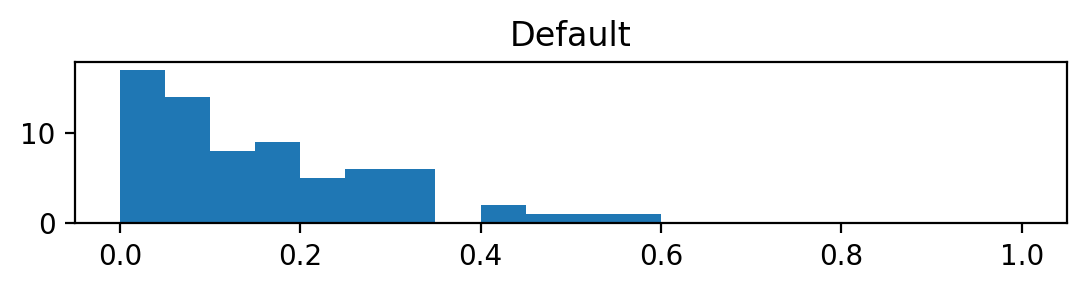

In [122]:
get_hist(df[df.es_reggaeton==1].acousticness,df[df.es_reggaeton==0].acousticness,
         values_range=[0,1],nbins=20,normed=True,name_image='2hist_acousticness.png')

               count      mean       std       min       25%    50%      75%  \
es_reggaeton                                                                   
0             2222.0  0.346486  0.360734  0.000002  0.021275  0.189  0.66725   
1               70.0  0.158725  0.132574  0.001650  0.056025  0.113  0.24350   

                max  
es_reggaeton         
0             0.996  
1             0.563  


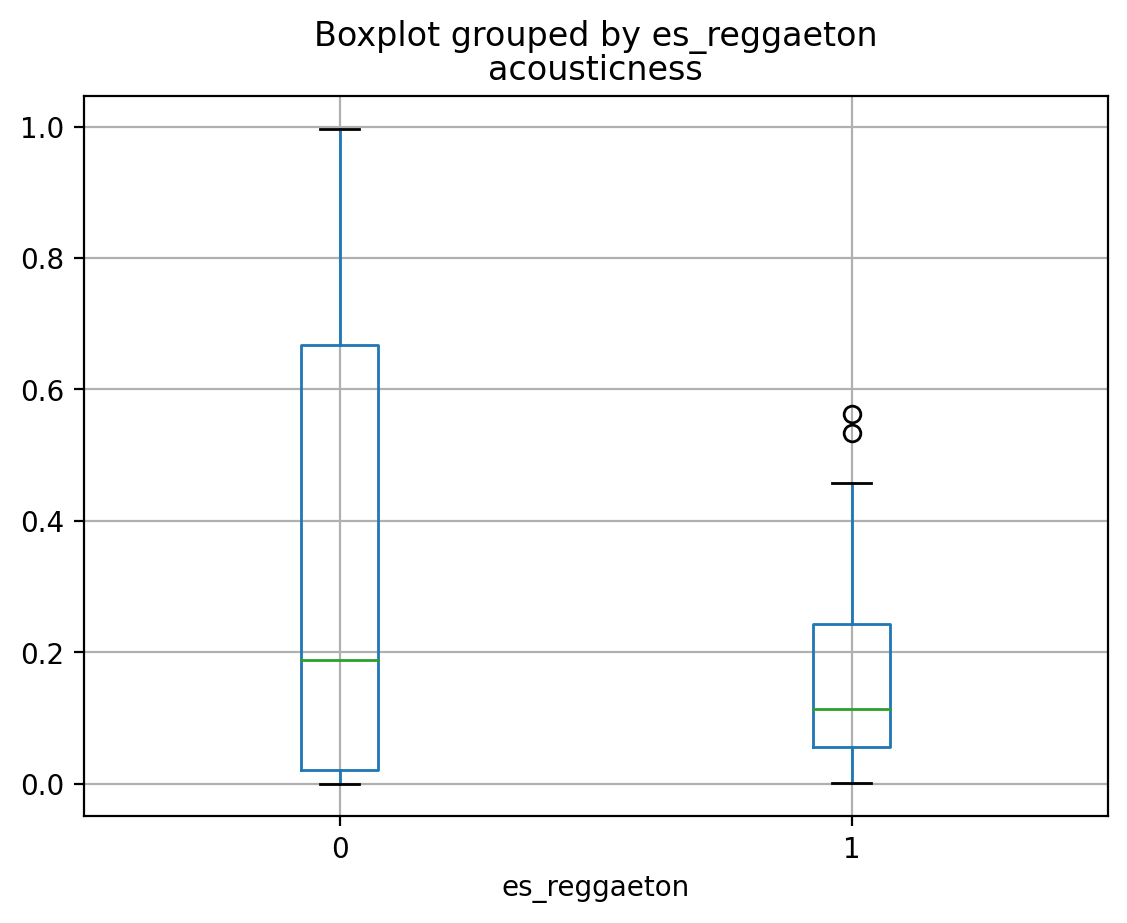

In [123]:
print(df.groupby('es_reggaeton')['acousticness'].describe())
df.boxplot(column='acousticness',by='es_reggaeton');

* **loudness:** Para la variabe loudness se evidencia que los valores para el reggaeton están más cercanos a 0dB que al -60dB, es decir que sean más ruidoso. De hecho, el mínimo en esta muestra para las canciones que no son de reggaeton es de -0.42dB mientras que para las que si está en -0.13dB y aproximadamente el 25% de las canciones que no son reggaeton tienen menos decibeles que este mínimo. **En consecuencia, esta es una variable que puede ser diferenciadora para aquellos registros con bajo loudness que se espera no entren dentro de la categoría de reggaeton**

**Referencias:**
*<https://community.plm.automation.siemens.com/t5/Testing-Knowledge-Base/Sound-Quality-Metrics-Loudness-and-Sones/ta-p/423283>*
*<https://www.johndcook.com/blog/2016/05/11/loudness-and-sharpness/>*

count    2292.000000
mean       -9.540138
std         6.086132
min       -42.117000
25%       -11.192750
50%        -7.892000
75%        -5.672000
max        -0.262000
Name: loudness, dtype: float64


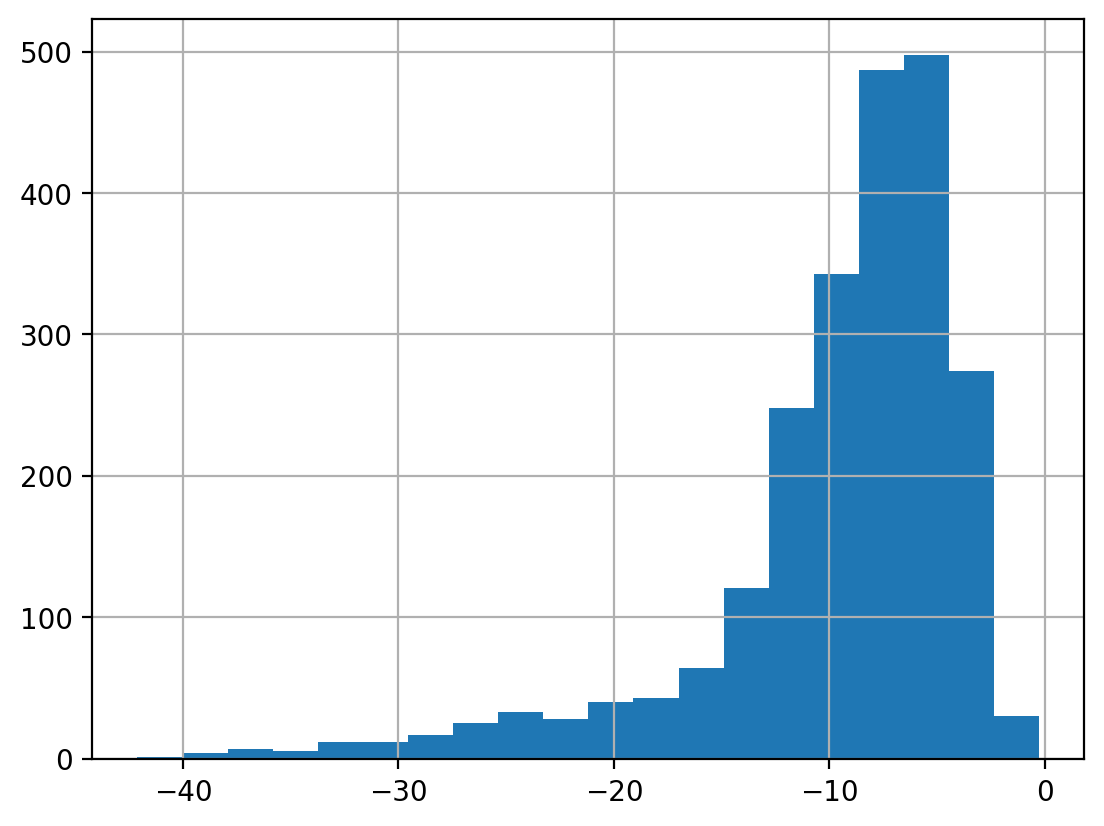

In [124]:
print(df.loudness.describe())
df.loudness.hist(bins=20);

AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

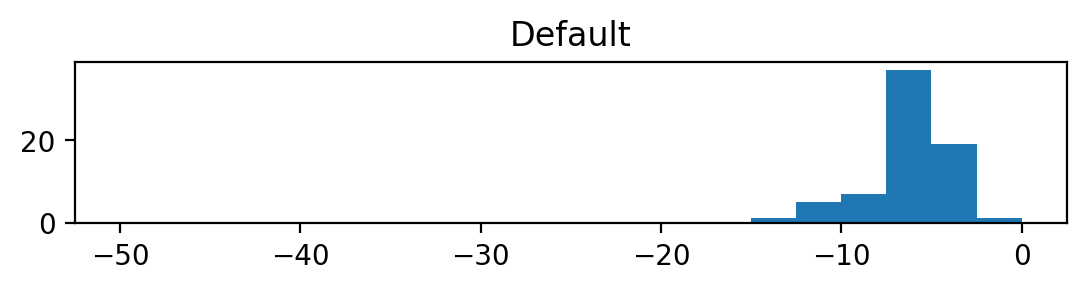

In [125]:
get_hist(df[df.es_reggaeton==1].loudness,df[df.es_reggaeton==0].loudness,
         values_range=[-50,0],nbins=20,normed=True,name_image='2hist_loudness.png')

               count      mean       std     min       25%     50%      75%  \
es_reggaeton                                                                  
0             2222.0 -9.641344  6.141384 -42.117 -11.31600 -8.0175 -5.69900   
1               70.0 -6.327571  2.243060 -13.268  -7.12875 -6.0310 -4.95975   

                max  
es_reggaeton         
0            -0.282  
1            -0.262  


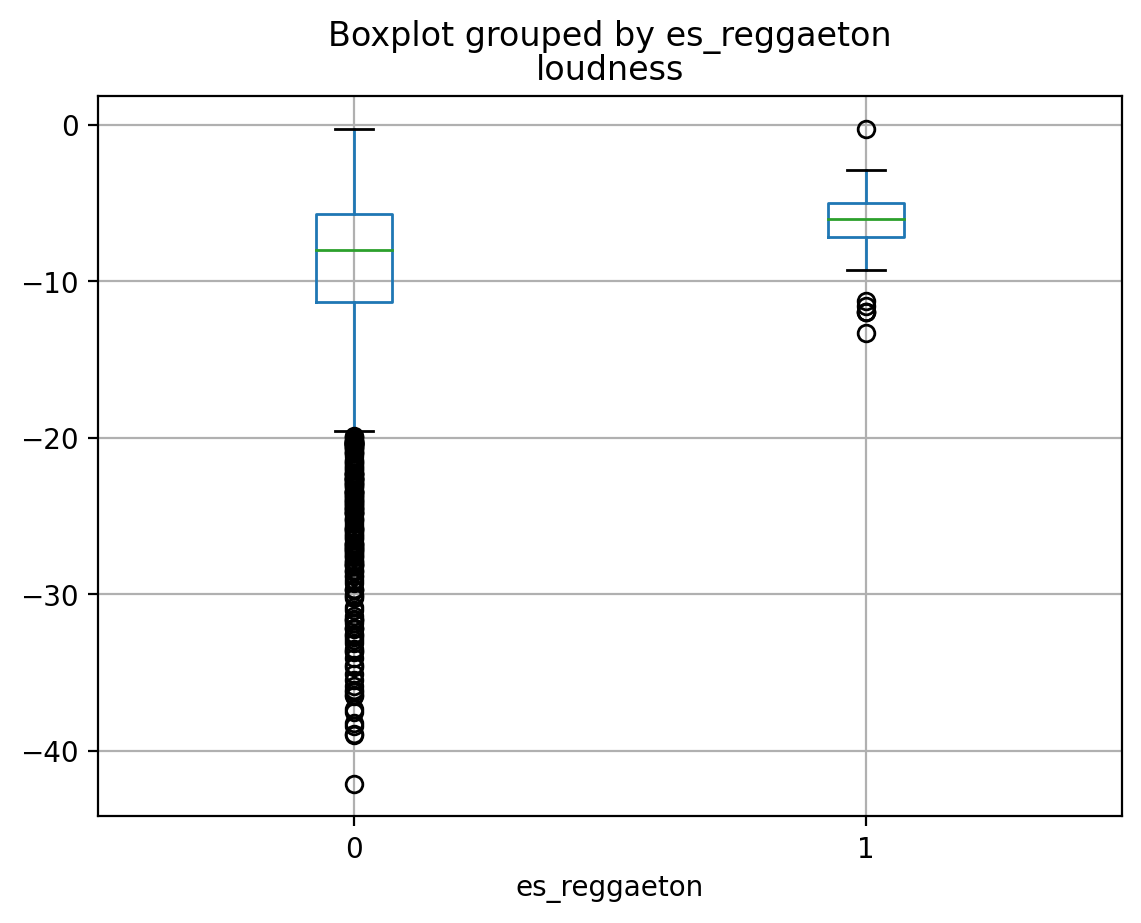

In [126]:
print(df.groupby('es_reggaeton')['loudness'].describe())
df.boxplot(column='loudness',by='es_reggaeton');

* **speechiness:** Para la variabe speechiness es esperable que la gran mayoría de los valores esté por debajo del 0.33, pues representan los valores que corresponden a tracks de música y sin/con poco discurso. En cuanto a las diferencias, vemos que las canciones de reggaeton siempre se mantienen bajo este umbral, mientras que hay 33 tracks (1.4%) que están en valores que indican una mezcla de música y discurso. **Es poco probable que esta variable sea efectivamente un elemento diferenciador salvo para esos casos muy extremos, por lo que es candidata a ser eliminada en la selección de variables.**

count    2292.000000
mean        0.069336
std         0.064496
min         0.023100
25%         0.035700
50%         0.046400
75%         0.072500
max         0.668000
Name: speechiness, dtype: float64


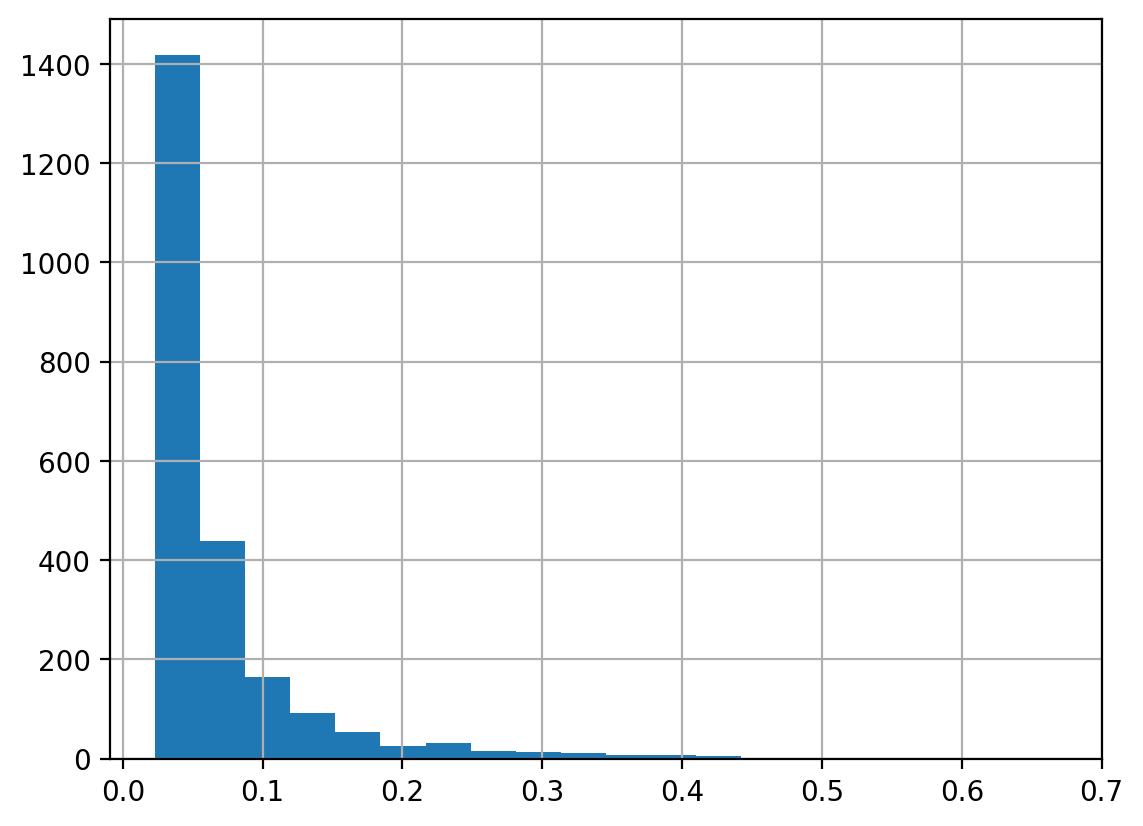

In [127]:
print(df.speechiness.describe())
df.speechiness.hist(bins=20);

AttributeError: Rectangle.set() got an unexpected keyword argument 'normed'

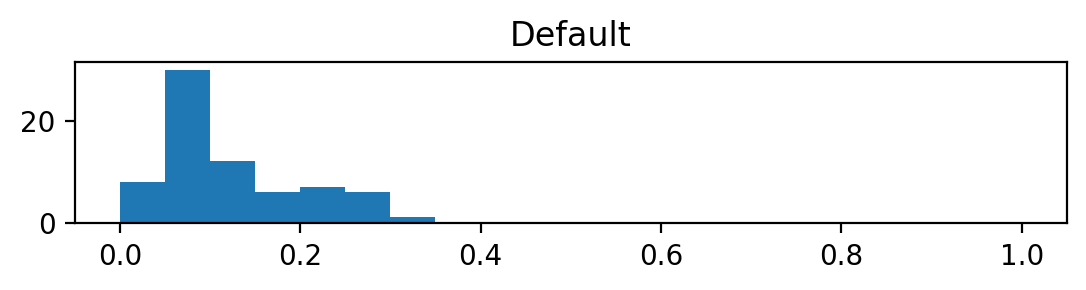

In [128]:
get_hist(df[df.es_reggaeton==1].speechiness,df[df.es_reggaeton==0].speechiness,
         values_range=[0,1],nbins=20,normed=True,name_image='2hist_speechiness.png')

In [ ]:
print(df.groupby('es_reggaeton')['speechiness'].describe())
df.boxplot(column='speechiness',by='es_reggaeton');

: 

In [ ]:
round(100*df[df.speechiness>=0.33].speechiness.count()/df.shape[0],1)

: 

* **instrumentalness:** Para la variabe instrumentalness es clara la diferenciación, vemos que solo hay 2 tracks de reggaeton que superan el 0.005 (su media) , mientras que en los tracks de otros géneros hay  un 30% (674 tracks) que sobrepasan el umbral del 0.1, es decir integran más instrumentos y menos vocalización. **Es una variable diferenciadora para aquellos valores no cercanos a 0.Se espera que esos tracks no sean reggaeton ya que este es el reggaeton es un género muy vocal y la mayoría de sus valores estará cercano a 0.**

In [ ]:
print(df.instrumentalness.describe())
df.instrumentalness.hist(bins=20);

: 

In [ ]:
get_hist(df[df.es_reggaeton==1].instrumentalness,df[df.es_reggaeton==0].instrumentalness,
         values_range=[0,1],nbins=20,normed=True,name_image='2hist_instrumentalness.png')

: 

In [ ]:
print(df.groupby('es_reggaeton')['instrumentalness'].describe())
df.boxplot(column='instrumentalness',by='es_reggaeton');

: 

In [ ]:
df[(df.instrumentalness>=0.1) & (df.es_reggaeton==0)].instrumentalness.count()

: 

* **liveness:** Para la variabe liveness no se aprecia una clara diferenciación en inicio, ** por lo que queda como candidata a ser eliminada en la selección de variables a menos que aporte información de forma conjunta con otra variable**

In [ ]:
print(df.liveness.describe())
df.liveness.hist(bins=20);

: 

In [ ]:
get_hist(df[df.es_reggaeton==1].liveness,df[df.es_reggaeton==0].liveness,
         values_range=[0,1],nbins=20,normed=True,name_image='2hist_liveness.png')

: 

In [ ]:
print(df.groupby('es_reggaeton')['liveness'].describe())
df.boxplot(column='liveness',by='es_reggaeton');

: 

* **valence:** Para la variabe valence se ve claramente que los track de reggaeton tienden a ser positivos, lo cual explica que más del 75% de ellos se situe en valores sobre 0.5. ** Dado que es muy raro que existieran tracks de reggaeton con valores más cercanos a 0, para los tracks con estos valores esta si parece ser una variable diferenciadora y por ende queda como candidata a ser seleccionada**

In [ ]:
print(df.valence.describe())
df.valence.hist(bins=20);

: 

In [ ]:
get_hist(df[df.es_reggaeton==1].valence,df[df.es_reggaeton==0].valence,
         values_range=[0,1],nbins=20,normed=True,name_image='2hist_valence.png')

: 

In [ ]:
print(df.groupby('es_reggaeton')['valence'].describe())
df.boxplot(column='valence',by='es_reggaeton');

: 

* **tempo:** Para la variabe *tempo* se ve claramente que los track de reggaeton tienden a estar en un rango muy acotado, que para la muestra es entre 84BPM y 102BPM para el 75% de los casos, mientras que en los otros tracks hay presencia de valores más extremos. ** Nuevamente la diferenciación vendría a ser en los valores más cercanos a los extremos, en los cuales se espera no encontrar tracks de reggaeton y por ende la diferenciación viene por identificar lo que no es reggaeton**

In [ ]:
print(df.tempo.describe())
df.tempo.hist(bins=20);

: 

In [ ]:
get_hist(df[df.es_reggaeton==1].tempo,df[df.es_reggaeton==0].tempo,
         values_range=[30,220],nbins=20,normed=True,name_image='2hist_tempo.png')

: 

In [ ]:
print(df.groupby('es_reggaeton')['tempo'].describe())
df.boxplot(column='tempo',by='es_reggaeton');

: 

* **duration:** Para la variable *duration* realizamos una conversión de milisegundos a minutos y pudimos observar que no pareciera existir una diferenciación relevanete entre tracks de reggaeton y no reggaeton, **por lo tanto queda como candidata a ser eliminada**

In [ ]:
df.loc[:,'duration']=((df.duration/1000)/60)

: 

In [ ]:
print(df.duration.describe())
df.duration.hist(bins=20);

: 

In [ ]:
get_hist(df[df.es_reggaeton==1].duration,df[df.es_reggaeton==0].duration,
         values_range=[0,25],nbins=20,normed=True,name_image='2hist_duration.png')

: 

In [ ]:
print(df.groupby('es_reggaeton')['duration'].describe())
df.boxplot(column='duration',by='es_reggaeton');

: 

* **Key Code: ** Para la variable *key_code* vemos que los valores de key no se distribuyen de la misma forma si el tracks es reggaeton o no, y que por ejemplo para los valores de 1 podemos ver mayor presencia de tracks de reggaeton. Adicionalmente, el test chi2 nos dice que no es posible afirmar que key y el tipo de track sean variables independienes, **por lo que consideramos la variable key_mode** como una variable candidata a ser seleccionada

In [ ]:
pd.crosstab(df.es_reggaeton,df.key_code, margins=True,normalize='index')

: 

In [ ]:
sns.countplot(x='es_reggaeton', hue='key_code', data=df, palette='Set1');

: 

In [ ]:
pd.crosstab(df.es_reggaeton,df.key_code, margins=True,normalize='columns')

: 

In [ ]:
sns.countplot(x='key_code', hue='es_reggaeton', data=df, palette='Set1');

: 

In [ ]:
chi2_test(var1=df.es_reggaeton,var2=df.key_code,alpha=0.99)

: 

* **mode_code** No se observan diferencias significativas y el test chi2 nos dice que ambas variables son independientes, ** por lo que esta variable queda como candidata a ser eliminada**

In [ ]:
pd.crosstab(df.es_reggaeton,df.mode_code, margins=True,normalize='index')

: 

In [ ]:
sns.countplot(x='es_reggaeton', hue='mode_code', data=df, palette='Set1');

: 

In [ ]:
pd.crosstab(df.es_reggaeton,df.mode_code, margins=True,normalize='columns')

: 

In [ ]:
sns.countplot(x='mode_code', hue='es_reggaeton', data=df, palette='Set1');

: 

In [ ]:
chi2_test(var1=df.es_reggaeton,var2=df.mode_code,alpha=0.99)

: 

### Análisis multivariado

* En esta etapa detectaremos las relaciones entre los features, con el objetivo de entender si es que hay variables que puedan estar entregando el mismo tipo de información


* Antes de buscar relaciones entre las variables, llevaremos los valores de las variables *valence* y *tempo* a una escala similar a la que se encuentran el resto de las variables numéricas. Para ello, hemos utilizado MinMaxScaler que nos permite llevar los valores mínimos y máximos entre 0 y 1 escalando al tamaño de la unidad

**Referencias:**
*<http://scikit-learn.org/stable/modules/preprocessing.html>*


In [ ]:
df.loc[:,'loudness_scale']=MinMaxScaler().fit_transform(df[['loudness']])
df.loc[:,'tempo_scale']=MinMaxScaler().fit_transform(df[['tempo']])
del df['loudness']
del df['tempo']
df.head()

: 

** Análisis de las variables numéricas por correlación de Pearson: **

* Como podemos ver, las variables energy-loundness están fuertemente correlacionadas de forma directa y las variables acousticness-energy, instrumentalness-loudness y acousticness-loudness lo están de forma inversa.


* Las variables valence-danceability, valence-energy,valence-loudness y acousticness-instrumentalness están medianamente correlacionadas de forma directa e valence-instrumentalness e instrumentalness-energy lo están de forma inversa.


* Todas son correlaciones esperables y representan bien las características musicales que normalmente *van de la mano*, por ejemplo: Mientras más acústica sea una canción también se espera que sea menos intensa y ruidosa (*energy*), y que las canciones con menos vocalización (más *instrumentalness*) estén correlacionadas positivamente con ser acústicas (más *acousticness*)


* Confirmada la relación logíca de cada correlación procedemos a establecer que al menos una de las 2 variables que tienen alta correlación y además representan características de la música que son similares o en general *van de la mano* son candidatas a ser eliminadas para disminuir la posibilidad de sobreajuste y duplicación de la información que entrega el modelo. Las candidatas son:

    * energy o loundness
    * acousticness o instrumentalness
    

* Si bien valence y danceability también están correlacionadas entre ellas, su correlación es media (y más leve con otras variables). Hacemos el supuesto de que aunque son dos características que reflejan atributos que frecuentemente *van de la mano* (que mientras más positiva es más bailable), creemos que por si solas aportan información que no alcanza a contener a la otra y es por ello que las dejamos inicialmente fuera de los candidatos para eliminar.  

In [ ]:
df.corr()

: 

In [ ]:
sns.heatmap(df.corr());

: 

** Análisis de las variables numéricas por análisis gráfico y test chi2: **

* Tanto el análisis gráfico como el test chi2 nos indican que no es posible determinar que ambas varibales son independientes, **lo cual da otro argumento más para eliminar *mode_key* en la selección de variables**

In [ ]:
pd.crosstab(df.mode_code,df.key_code, margins=True,normalize='columns')

: 

In [ ]:
sns.countplot(x='key_code', hue='mode_code', data=df, palette='Set1');

: 

In [ ]:
pd.crosstab(df.mode_code,df.key_code, margins=True,normalize='index')

: 

In [ ]:
sns.countplot(x='mode_code', hue='key_code', data=df, palette='Set1');

: 

In [ ]:
chi2_test(var1=df.key_code,var2=df.mode_code,alpha=0.99)

: 

In [ ]:
df.to_csv('data_entrega_pregunta_2.csv',sep=',',header=True,encoding='utf-8',index=False)

: 